In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark import  SparkContext
import os

In [2]:
os.environ["JAVA_HOME"] = r'C:\Program Files\Java\jre-1.8'
os.environ["PYSPARK_PYTHON"] = "python"

In [16]:
# Define the ticker symbol
ticker_symbol = 'TR'  # Apple Inc. as an example

# Get the stock data
stock_data = yf.download(ticker_symbol, start='1987-12-30', end='2017-02-15')
stock_data["Date"] = stock_data.index
stock_data.index = np.arange(len(stock_data))

[*********************100%%**********************]  1 of 1 completed


In [17]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,Date
0,3.546842,3.736852,3.515174,3.736852,2.337734,49734,1987-12-30
1,3.736852,3.895193,3.736852,3.895193,2.436791,27630,1987-12-31
2,3.895193,4.021866,3.863525,3.926861,2.456603,44208,1988-01-04
3,3.990198,4.243543,3.990198,4.085202,2.555659,124731,1988-01-05
4,4.148539,4.164373,3.990198,4.132705,2.585376,66313,1988-01-06
...,...,...,...,...,...,...,...
7337,31.573156,31.740652,31.321911,31.531282,29.125160,46807,2017-02-08
7338,31.573156,32.243145,31.531282,31.740652,29.318556,77613,2017-02-09
7339,31.908150,32.075645,31.531282,31.615030,29.202517,59344,2017-02-10
7340,31.866276,31.908150,30.861296,31.112539,28.738367,114748,2017-02-13


In [21]:
spark: SparkSession = SparkSession.builder.master("local").getOrCreate()

In [50]:
df_TR = spark.createDataFrame(stock_data)
df_TR.createOrReplaceTempView("tr_stock")

In [51]:
df_TR.show()

+------------------+------------------+------------------+------------------+------------------+------+-------------------+
|              Open|              High|               Low|             Close|         Adj Close|Volume|               Date|
+------------------+------------------+------------------+------------------+------------------+------+-------------------+
| 3.546842098236084| 3.736851930618286|  3.51517391204834| 3.736851930618286| 2.337735414505005| 49734|1987-12-30 00:00:00|
| 3.736851930618286| 3.895193099975586| 3.736851930618286| 3.895193099975586|  2.43679141998291| 27630|1987-12-31 00:00:00|
| 3.895193099975586|4.0218658447265625| 3.863524913787842| 3.926861047744751|2.4566032886505127| 44208|1988-01-04 00:00:00|
|3.9901978969573975|4.2435431480407715|3.9901978969573975| 4.085202217102051|2.5556585788726807|124731|1988-01-05 00:00:00|
| 4.148539066314697|  4.16437292098999|3.9901978969573975| 4.132705211639404|2.5853776931762695| 66313|1988-01-06 00:00:00|
| 4.1168

In [52]:
df_TR.columns

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date']

In [53]:
df_return = spark.sql("""
    SELECT
        date_trade,
        close_price,
        LOG(close_price/previous_close) AS return_value
    FROM ( 
        SELECT
            *,
            TO_DATE(Date) as date_trade,
            LAG(`Adj Close`) OVER(ORDER BY Date) AS previous_close,
            `Adj Close` as close_price
        FROM tr_stock
    ) WHERE previous_close IS NOT NULL
    ORDER BY date_trade
""")
df_return.show(20)

+----------+------------------+--------------------+
|date_trade|       close_price|        return_value|
+----------+------------------+--------------------+
|1987-12-31|  2.43679141998291| 0.04149949293710022|
|1988-01-04|2.4566032886505127|0.008097436687612624|
|1988-01-05|2.5556585788726807| 0.03953033243028412|
|1988-01-06|2.5853776931762695|0.011561655581095434|
|1988-01-07|  2.87264084815979| 0.10536015600723131|
|1988-01-08|2.5358479022979736|-0.12470370349878103|
|1988-01-11|2.5160372257232666|-0.00784292501560...|
|1988-01-12|2.5358479022979736|  0.0078429250156051|
|1988-01-13| 2.595282793045044|0.023167427463814935|
|1988-01-14|2.5556585788726807|-0.01538553555336...|
|1988-01-15|2.5358479022979736|-0.00778189191045...|
|1988-01-18|2.5259416103363037|-0.00391415114534...|
|1988-01-19|2.5358479022979736|0.003914151145341422|
|1988-01-20| 2.496225357055664|-0.01574832562838...|
|1988-01-21|2.5061306953430176|0.003960274370589895|
|1988-01-22|2.4764134883880615|-0.011928668663

In [54]:
df_return_pandas = df_return.toPandas()

In [55]:
df_return_pandas

,date_trade,close_price,return_value
0,1987-12-31,2.436791,0.041499
1,1988-01-04,2.456603,0.008097
2,1988-01-05,2.555659,0.039530
3,1988-01-06,2.585378,0.011562
4,1988-01-07,2.872641,0.105360
...,...,...,...
7336,2017-02-08,29.125158,-0.002653
7337,2017-02-09,29.318552,0.006618
7338,2017-02-10,29.202520,-0.003965
7339,2017-02-13,28.738373,-0.016022


In [57]:
x = np.arange(1, len(df_return_pandas) + 1)

In [58]:
y  = df_return_pandas["return_value"]

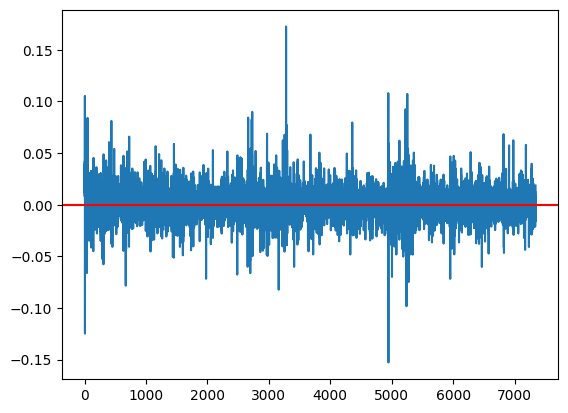

In [59]:
plt.plot(x, y)
plt.axhline(y=0, color='r', linestyle='-')

In [60]:
np.mean(df_return_pandas["return_value"])

0.0003443288004340364

In [61]:
np.min(df_return_pandas["return_value"])

-0.1527466396527211

In [63]:
np.std(df_return_pandas["return_value"])*np.sqrt(252)

0.24433443985175624

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,
          1.,   1.,   2.,   1.,   3.,   0.,   3.,   1.,   4.,  11.,  10.,
         16.,  15.,  25.,  33.,  55.,  78.,  99., 181., 225., 338., 439.,
        604., 776., 946., 642., 686., 577., 425., 318., 225., 175., 111.,
         83.,  67.,  44.,  31.,  22.,  11.,   9.,   9.,   6.,   4.,   3.,
          3.,   4.,   1.,   0.,   1.,   2.,   3.,   0.,   2.,   1.,   0.,
          0.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.15274664, -0.14949285, -0.14623905, -0.14298526, -0.13973147,
        -0.13647767, -0.13322388, -0.12997009, -0.12671629, -0.1234625 ,
        -0.12020871, -0.11695491, -0.11370112, -0.11044733, -0.10719353,
        -0.10393974, -0.10068595, -0.09743215, -0.09417836, -0.09092457,
        -0.08767077, -0.08

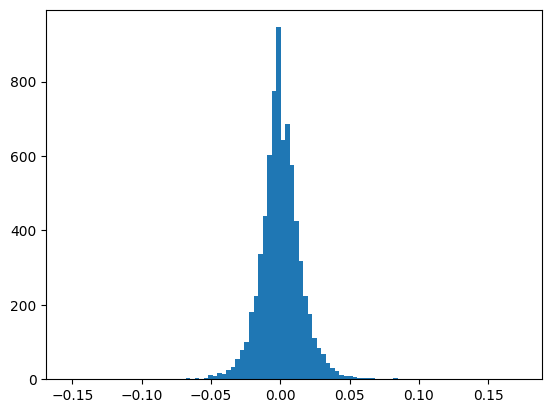

In [65]:
plt.hist(df_return_pandas["return_value"], 100)